In [1]:
%load_ext autoreload
%autoreload 2

Currently, to run this tutorial, from within a climada_python git repo please run:

```
mamba create -n climada_trajectory "python==3.11.*"
git fetch
git checkout feature/risk_trajectory
mamba env update -n climada_trajectory -f requirements/env_climada.yml
mamba activate climada_trajectory
python -m pip install -e ./

```

To be able to select that environment in jupyter you possibly might also need:

```
mamba install ipykernel
python -m ipykernel install --user --name climada_trajectory
```

# Important disclaimers

## Interpolation of risk can be... risky

The purpose of this module is to improve the evaluation of risk in between two "known" points in time.

It relies on interpolation (linear by default) of impacts and risk metrics in between the different points, 
which may lead to incoherent results in cases where this simplification drifts too far from reality.

As always users should carefully consider if the tool fits the purpose and if the limitations 
remain acceptable, even more so when used to design Disaster Risk Reduction or Climate Change Adaptation measures.

## Memory and computation requirements

This module adds a new dimension (time) to the risk, as such, it **multiplies** the memory and computation requirement along that dimension (although we avoid running a full-fledge impact computation for each "interpolated" point, we still have to define an impact matrix for each of those). 

This can of course (very) quickly increase the memory and computation requirements for bigger data. We encourage you to first try on small examples before running big computations.


# Using the `trajectories` module

The fundamental idea behing the `trajectories` module is to enable a better assessment of the evolution of risk over time.

Currently it proposes to look at the evolution between defined points in time and in the future we plan to also allow using a timeseries-oriented approach.

In this tutorial we present the current possibilities offered by the module.

## `Snapshot`: A snapshot of risk at a specific year

We use `Snapshot` objects to define a point in time for risk. This object acts as a wrapper of the classic risk framework composed of Exposure, Hazard and Vulnerability. As such it is defined for a specific date (usually a year), and contains references to an `Exposures`, a `Hazard`, and an `ImpactFuncSet` object.

Next we show how to instantiate such a `Snapshot`. Note however that they are of little use by themselves, and what users will really use are `RiskTrajectory` which we present right after.

In [2]:
from climada.engine.impact_calc import ImpactCalc
from climada.util.api_client import Client
from climada.entity import ImpactFuncSet, ImpfTropCyclone
from climada.trajectories.snapshot import Snapshot

client = Client()

exp_present = client.get_litpop(country="Haiti")

haz_present = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "historical",
        "nb_synth_tracks": "10",
    },
)
exp_present.assign_centroids(haz_present, distance="approx")

impf_set = ImpactFuncSet([ImpfTropCyclone.from_emanuel_usa()])
exp_present.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_present.gdf["impf_TC"] = 1

# Trajectories allow to look at the risk faced by specifics groups of coordinates based on the "group_id" column of the exposure
exp_present.gdf["group_id"] = (exp_present.gdf["value"] > 500000) * 1
snap = Snapshot(exp_present, haz_present, impf_set, 2018)

ERROR 1: PROJ: proj_create_from_database: Open of /home/sjuhel/miniforge3/envs/cb_refactoring/share/proj failed
/home/sjuhel/miniforge3/envs/cb_refactoring/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


2025-09-12 14:44:39,261 - climada.entity.exposures.base - INFO - Reading /home/sjuhel/climada/data/exposures/litpop/LitPop_150arcsec_HTI/v3/LitPop_150arcsec_HTI.hdf5
2025-09-12 14:44:44,907 - climada.hazard.io - INFO - Reading /home/sjuhel/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_HTI_1980_2020/v2/tropical_cyclone_10synth_tracks_150arcsec_HTI_1980_2020.hdf5
2025-09-12 14:44:44,935 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2025-09-12 14:44:44,937 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100


2025-09-12 14:44:45,284 - climada.util.coordinates - INFO - Raster from resolution 0.04166665999999708 to 0.04166665999999708.


<Axes: title={'center': 'TC 1: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

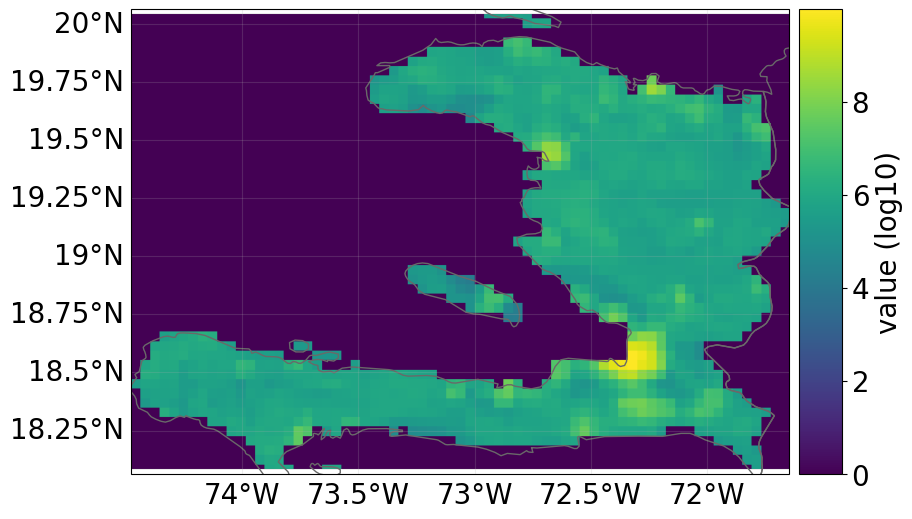

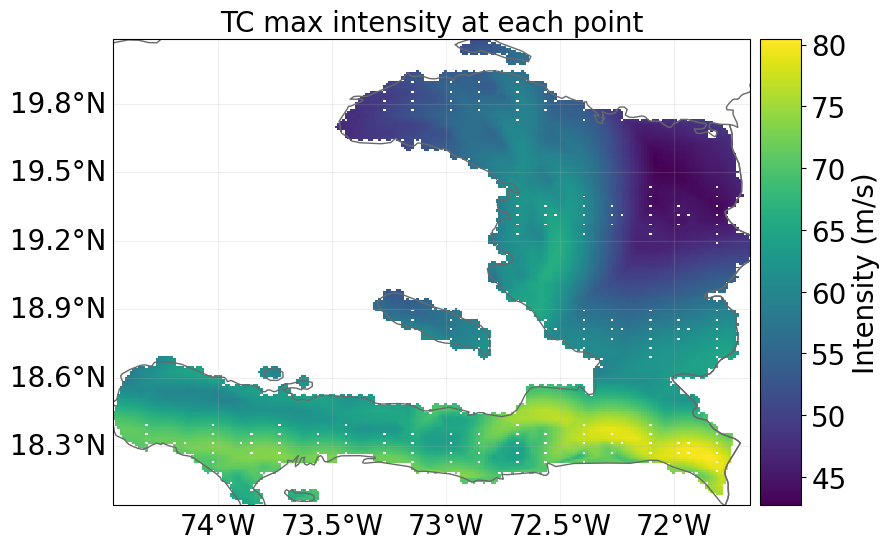

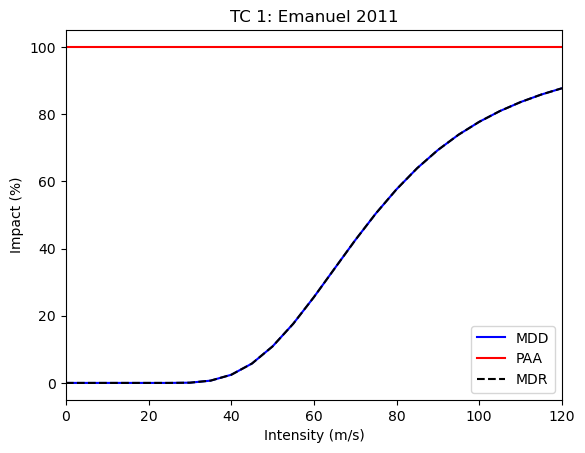

In [3]:
snap.exposure.plot_raster()
snap.hazard.plot_intensity(0)
snap.impfset.plot()

As stated previously, it makes little sense to define a Snapshot alone, so your main entry point should rather be the `RiskTrajectory` object.

`RiskTrajectory` uses one or more `CalcRiskPeriod` under the hood that handles the computation to estimate the different risk metrics at every date between pairs of consecutive `Snapshot`.

In the following we focus on a trajectory between only two snapshot, but as you can learn in the lasts part of this guide you can actually create a trajectory of risk with any number of snapshots.

So first, let us define `Snapshot` for a future point in time. We will increase the value of the exposure following a certain growth rate, and use future tropical cyclone data.

In [4]:
import copy

future_year = 2040
exp_future = copy.deepcopy(exp_present)
exp_future.ref_year = future_year
n_years = exp_future.ref_year - exp_present.ref_year + 1
growth_rate = 1.02
growth = growth_rate**n_years
exp_future.gdf["value"] = exp_future.gdf["value"] * growth

haz_future = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "rcp60",
        "ref_year": str(future_year),
        "nb_synth_tracks": "10",
    },
)
exp_future.assign_centroids(haz_future, distance="approx")
impf_set = ImpactFuncSet(
    [
        ImpfTropCyclone.from_emanuel_usa(v_half=60.0),
    ]
)
exp_future.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_future.gdf["impf_TC"] = 1

2025-09-12 14:45:06,403 - climada.hazard.io - INFO - Reading /home/sjuhel/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_rcp60_HTI_2040/v2/tropical_cyclone_10synth_tracks_150arcsec_rcp60_HTI_2040.hdf5
2025-09-12 14:45:06,427 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2025-09-12 14:45:06,427 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2025-09-12 14:45:06,427 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2025-09-12 14:45:06,429 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100


<Axes: title={'center': 'TC 1: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

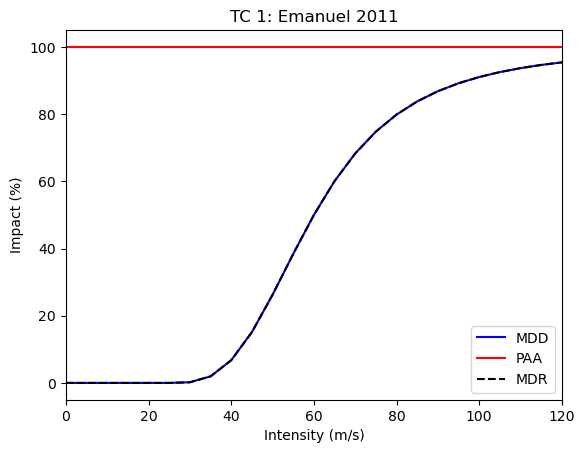

In [84]:
impf_set.plot()

In [6]:
snap2 = Snapshot(exp_future, haz_future, impf_set, 2040)

Now we can define a list of two snapshots, present and future:

In [86]:
snapcol = [snap, snap2]

Based on such a list of snapshots, we can then evaluate a risk trajectory using a `RiskTrajectory` object.

This object will hold risk metrics for all the dates between the different snapshots in the given collection for a given time resolution (one year by default).

In this example, from the snapshot in 2018 to the one in 2040. 

Note that this can require a bit of computation and memory, especially for large regions or extended range of time.
The computations are only run when needed, not during instantiation, and are cached once computed.

In [8]:
from climada.trajectories.risk_trajectory import RiskTrajectory

risk_traj = RiskTrajectory(snapcol)

From this object you can access different risk metrics:

* Average Annual Impact (aai) both for all exposure points (group == "All") and specific groups of exposure points (defined by a "group_id" in the exposure).
* Estimated impact for different return periods (100, 500 and 1000 by default) **-> Pretty sure this is plain wrong as it sums up the values of each year**

Both as totals over the whole period:

In [88]:
risk_traj.per_period_risk_metrics()

2025-09-12 11:48:45,353 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2025-09-12 11:48:45,353 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2025-09-12 11:48:45,354 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2025-09-12 11:48:45,355 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2025-09-12 11:48:45,359 - climada.engine.impact_calc - INFO - Calculating impact for 3987 assets (>0) and 43560 events.
2025-09-12 11:48:45,369 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2025-09-12 11:48:45,370 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2025-09-12 11:48:45,370 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2025-09-12 11:48:45,372 - climada.util.c

,period,group,measure,metric,risk
0,2018-01-01 to 2040-01-01,0,no_measure,aai,1.414905e+07
1,2018-01-01 to 2040-01-01,1,no_measure,aai,9.465607e+09
2,2018-01-01 to 2040-01-01,All,no_measure,aai,9.479757e+09
3,2018-01-01 to 2040-01-01,All,no_measure,rp_100,3.117856e+11
4,2018-01-01 to 2040-01-01,All,no_measure,rp_50,1.782113e+11
5,2018-01-01 to 2040-01-01,All,no_measure,rp_500,8.083646e+11


Or on a per-date basis:

In [89]:
risk_traj.per_date_risk_metrics()

,group,date,measure,metric,risk
0,All,2018-01-01,no_measure,aai,1.840432e+08
1,All,2019-01-01,no_measure,aai,2.000396e+08
2,All,2020-01-01,no_measure,aai,2.166844e+08
3,All,2021-01-01,no_measure,aai,2.339834e+08
4,All,2022-01-01,no_measure,aai,2.519424e+08
...,...,...,...,...,...
41,1,2038-01-01,no_measure,aai,6.328297e+08
42,0,2039-01-01,no_measure,aai,9.943382e+05
43,1,2039-01-01,no_measure,aai,6.628505e+08
44,0,2040-01-01,no_measure,aai,1.040877e+06


You can also plot the "components" of the change in risk via a waterfall graph:

   - The 'base risk', i.e., the risk without change in hazard or exposure, compared to trajectory's earliest date.
   - The 'exposure contribution', i.e., the additional risks due to change in exposure (only)
   - The 'hazard contribution', i.e., the additional risks due to change in hazard (only)
   - The 'vulnerability contribution', i.e., the additional risks due to change in vulnerability (only)
   - The 'interaction contribution', i.e., the additional risks due to the interaction term

<Axes: title={'center': 'Risk at 2018-01-01 and 2040-01-01 (Average impact)'}, ylabel='USD'>

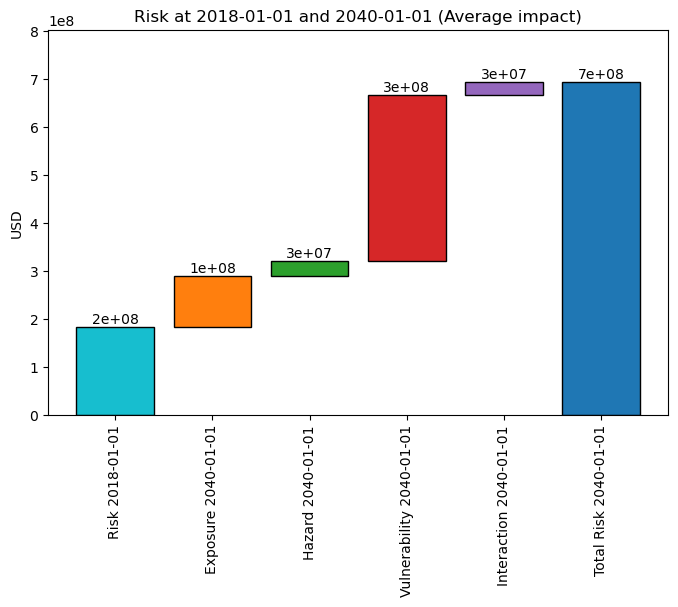

In [90]:
risk_traj.plot_waterfall()

And as well on a per date basis (keep in mind this is an interpolation, thus should be interpreted with caution):

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Risk between 2018-01-01 and 2040-01-01 (Average impact)'}, ylabel='USD'>)

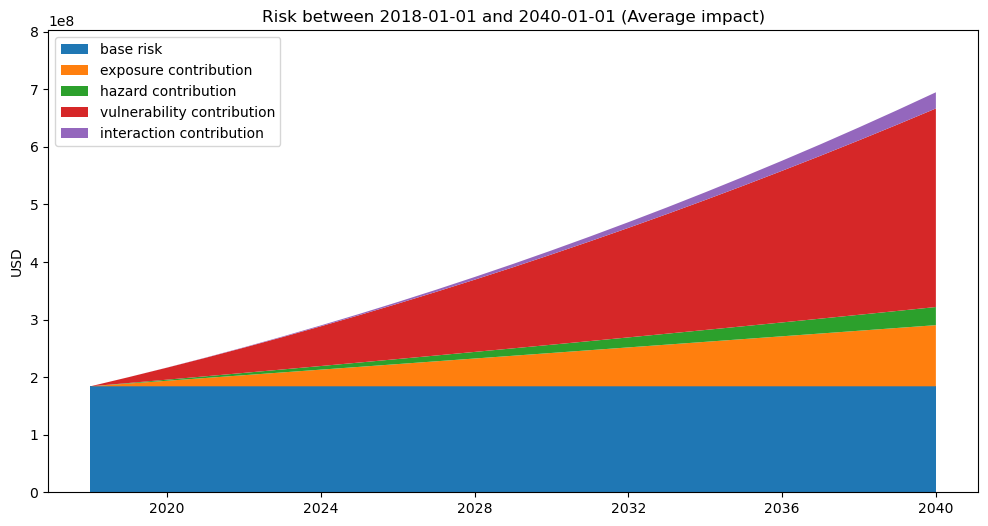

In [91]:
risk_traj.plot_per_date_waterfall()

### DiscRates

To correctly assess the future risk, you may also want to apply a discount rate, in order to express future costs in net present value.

This can easily be done providing an instance of the already existing `DiscRates` class when instantiating the trajectory:

In [42]:
from climada.entity import DiscRates
import numpy as np

year_range = np.arange(exp_present.ref_year, exp_future.ref_year + 1)
annual_discount_stern = np.ones(n_years) * 0.014
discount_stern = DiscRates(year_range, annual_discount_stern)

In [43]:
discounted_risk_traj = RiskTrajectory(snapcol, risk_disc=discount_stern)

In [47]:
discounted_risk_traj.per_date_risk_metrics()

,date,group,measure,metric,risk
0,2018-01-01,All,no_measure,aai,1.840432e+08
1,2019-01-01,All,no_measure,aai,1.972777e+08
2,2020-01-01,All,no_measure,aai,2.107423e+08
3,2021-01-01,All,no_measure,aai,2.244250e+08
4,2022-01-01,All,no_measure,aai,2.383140e+08
...,...,...,...,...,...
41,2038-01-01,1,no_measure,aai,4.792120e+08
42,2039-01-01,0,no_measure,aai,7.425694e+05
43,2039-01-01,1,no_measure,aai,4.950152e+08
44,2040-01-01,0,no_measure,aai,7.665923e+05


To ease comparison, you can ask for metrics without NPV by asking explicitly:

In [46]:
discounted_risk_traj.per_date_risk_metrics(npv=False)

,group,date,measure,metric,risk
0,All,2018-01-01,no_measure,aai,1.840432e+08
1,All,2019-01-01,no_measure,aai,2.000396e+08
2,All,2020-01-01,no_measure,aai,2.166844e+08
3,All,2021-01-01,no_measure,aai,2.339834e+08
4,All,2022-01-01,no_measure,aai,2.519424e+08
...,...,...,...,...,...
41,1,2038-01-01,no_measure,aai,6.328297e+08
42,0,2039-01-01,no_measure,aai,9.943382e+05
43,1,2039-01-01,no_measure,aai,6.628505e+08
44,0,2040-01-01,no_measure,aai,1.040877e+06


<Axes: xlabel='date', ylabel='risk'>

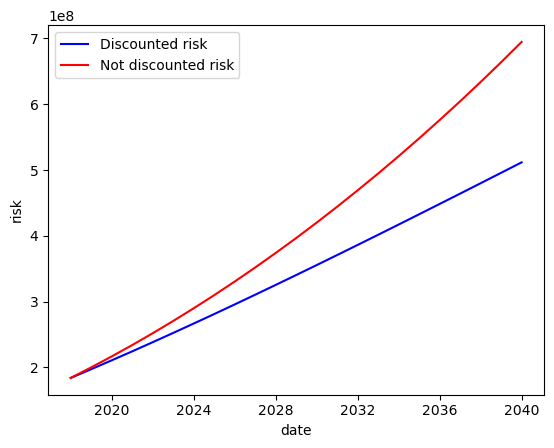

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.lineplot(
    discounted_risk_traj.per_date_risk_metrics().loc[
        (discounted_risk_traj.per_date_risk_metrics()["metric"] == "aai")
        & (discounted_risk_traj.per_date_risk_metrics()["group"] == "All")
    ],
    x="date",
    y="risk",
    color="blue",
    label="Discounted risk",
)
sns.lineplot(
    discounted_risk_traj.per_date_risk_metrics(npv=False).loc[
        (discounted_risk_traj.per_date_risk_metrics()["metric"] == "aai")
        & (discounted_risk_traj.per_date_risk_metrics()["group"] == "All")
    ],
    x="date",
    y="risk",
    ax=g,
    color="red",
    label="Not discounted risk",
)

# Advanced usage

In this section we present some more advanced features and use of this module.

## Higher number of snapshots

You can seemlessly use more than two snapshots to define a risk trajectory.
The interpolation will be done between each pair of consecutive snapshots, 
and all results will be collected together.

In [ ]:
from climada.engine.impact_calc import ImpactCalc
from climada.util.api_client import Client
from climada.entity import ImpactFuncSet, ImpfTropCyclone
from climada.trajectories.snapshot import Snapshot
from climada.trajectories.risk_trajectory import RiskTrajectory
import copy

client = Client()


future_years = [2040, 2060, 2080]

exp_present = client.get_litpop(country="Haiti")
haz_present = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "historical",
        "nb_synth_tracks": "10",
    },
)
exp_present.assign_centroids(haz_present, distance="approx")

impf_set = ImpactFuncSet([ImpfTropCyclone.from_emanuel_usa()])
exp_present.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_present.gdf["impf_TC"] = 1
exp_present.gdf["group_id"] = (exp_present.gdf["value"] > 500000) * 1

snapcol = [Snapshot(exp_present, haz_present, impf_set, 2018)]

for year in future_years:
    exp_future = copy.deepcopy(exp_present)
    exp_future.ref_year = year
    n_years = exp_future.ref_year - exp_present.ref_year + 1
    growth_rate = 1.02
    growth = growth_rate**n_years
    exp_future.gdf["value"] = exp_future.gdf["value"] * growth

    haz_future = client.get_hazard(
        "tropical_cyclone",
        properties={
            "country_name": "Haiti",
            "climate_scenario": "rcp60",
            "ref_year": str(year),
            "nb_synth_tracks": "10",
        },
    )
    exp_future.assign_centroids(haz_future, distance="approx")
    impf_set = ImpactFuncSet(
        [
            ImpfTropCyclone.from_emanuel_usa(v_half=60.0),
        ]
    )
    exp_future.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
    exp_future.gdf["impf_TC"] = 1
    snapcol.append(Snapshot(exp_future, haz_future, impf_set, year))

2025-09-12 13:35:07,107 - climada.entity.exposures.base - INFO - Reading /home/sjuhel/climada/data/exposures/litpop/LitPop_150arcsec_HTI/v3/LitPop_150arcsec_HTI.hdf5
2025-09-12 13:35:12,504 - climada.hazard.io - INFO - Reading /home/sjuhel/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_HTI_1980_2020/v2/tropical_cyclone_10synth_tracks_150arcsec_HTI_1980_2020.hdf5
2025-09-12 13:35:12,531 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2025-09-12 13:35:12,533 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2025-09-12 13:35:18,244 - climada.hazard.io - INFO - Reading /home/sjuhel/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_rcp60_HTI_2040/v2/tropical_cyclone_10synth_tracks_150arcsec_rcp60_HTI_2040.hdf5
2025-09-12 13:35:18,270 - climada.entity.exposures.base - INFO - Exposures matching centroid

In [101]:
risk_traj = RiskTrajectory(snapcol)

<Axes: title={'center': 'Evolution of the components of risk between 2018-01-01 and 2080-01-01 (Average impact)'}, ylabel='USD'>

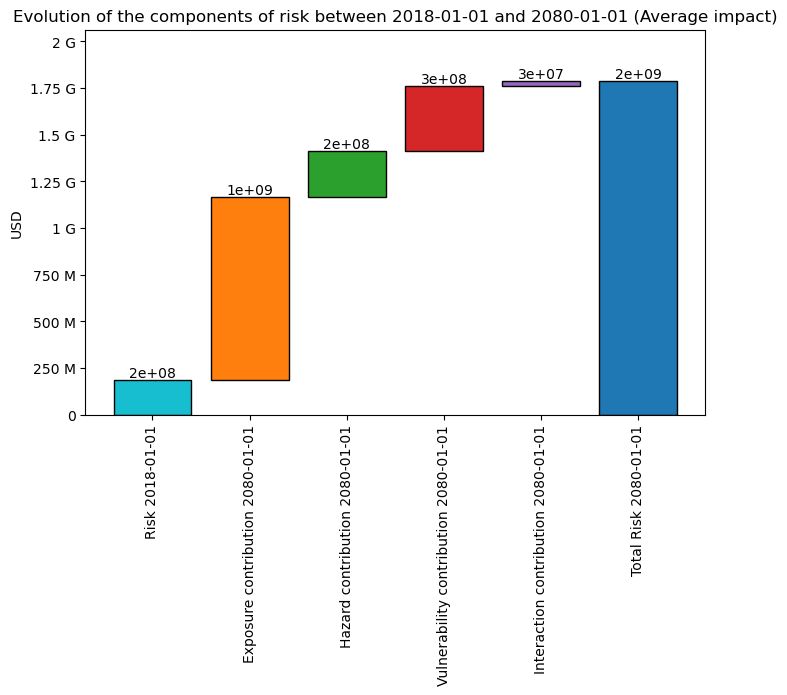

In [106]:
risk_traj.plot_waterfall()

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Risk between 2018-01-01 and 2080-01-01 (Average impact)'}, ylabel='USD'>)

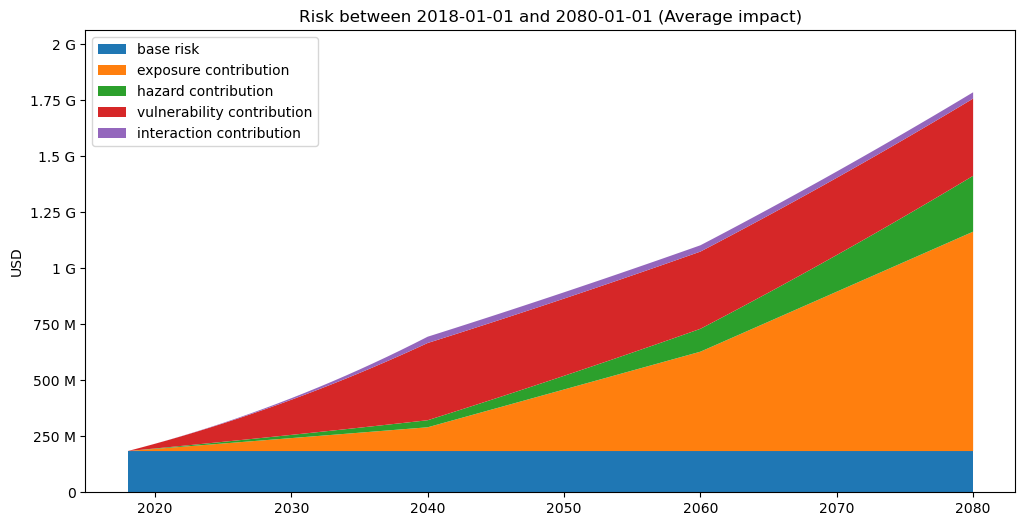

In [107]:
risk_traj.plot_per_date_waterfall()

## Non-yearly date index

You can use any valid pandas [frequency string](https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases) for the time resolution,
for instance "5YS" for every five years. This reduces the resolution of the interpolation, which can reduce the required computations at the cost of "precision".
Conversely you can also increase the time resolution to a monthly base for instance

Keep in mind that risk metrics are still computed the same way so you would still get "Average Annual Impacts"
values for every months and not average monthly ones !

In [126]:
snapcol = [snap, snap2]
risk_traj = RiskTrajectory(snapcol, time_resolution="5YS")
risk_traj.per_date_risk_metrics().head()

,group,date,measure,metric,risk
0,All,2018-01-01,no_measure,aai,1.840432e+08
1,All,2023-01-01,no_measure,aai,2.801311e+08
2,All,2028-01-01,no_measure,aai,3.966228e+08
3,All,2033-01-01,no_measure,aai,5.344827e+08
4,All,2038-01-01,no_measure,aai,6.946753e+08


In [129]:
snapcol = [snap, snap2]

# Here we use "1MS" to get a monthly basis
risk_traj = RiskTrajectory(snapcol, time_resolution="1MS")

# We would have to divide results by 12 to get "average monthly impacts"
risk_traj.per_date_risk_metrics().head()

,group,date,measure,metric,risk
0,All,2018-01-01,no_measure,aai,1.840432e+08
1,All,2018-02-01,no_measure,aai,1.853516e+08
2,All,2018-03-01,no_measure,aai,1.866645e+08
3,All,2018-04-01,no_measure,aai,1.879819e+08
4,All,2018-05-01,no_measure,aai,1.893037e+08


## Non-linear interpolation

The module allows you to define your own interpolation strategy. Thus you can decide how to interpolate along each dimension of risk (Exposure, Hazard and Vulnerability).
This is done via `InterpolationStrategy` objects, which simply require three functions stating how to interpolate along each dimensions.

For convenience the module provides an `AllLinearStrategy` (risk is linearly interpolated along all dimensions) and a `ExponentialExposureStrategy` (risk uses exponential interpolation along exposure, and linear for the two other dimensions)

<Axes: xlabel='date', ylabel='risk'>

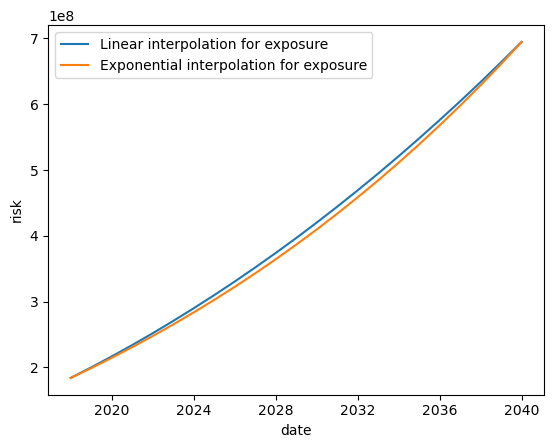

In [19]:
from climada.trajectories.interpolation import ExponentialExposureStrategy
import seaborn as sns

exp_interp = ExponentialExposureStrategy(rate=1.02)

snapcol = [snap, snap2]
risk_traj = RiskTrajectory(snapcol)
risk_traj_exp = RiskTrajectory(snapcol, interpolation_strategy=exp_interp)

sns.lineplot(
    risk_traj.aai_metrics(),
    x="date",
    y="risk",
    label="Linear interpolation for exposure",
)
sns.lineplot(
    risk_traj_exp.aai_metrics(),
    x="date",
    y="risk",
    label="Exponential interpolation for exposure",
)

## Spatial mapping

You can access a DataFrame with the estimated annual impacts at each coordinates through "eai_metrics" which can easily be merged to the exposure GeoDataFrame:

In [26]:
df = risk_traj.eai_metrics()
df

,group,date,measure,metric,coord_id,risk
0,1,2018-01-01,no_measure,eai,0,3515.056865
1,1,2019-01-01,no_measure,eai,0,3822.351335
2,1,2020-01-01,no_measure,eai,0,4142.027736
3,1,2021-01-01,no_measure,eai,0,4474.189828
4,1,2022-01-01,no_measure,eai,0,4818.941374
...,...,...,...,...,...,...
30562,1,2036-01-01,no_measure,eai,1328,4587.481962
30563,1,2037-01-01,no_measure,eai,1328,4827.783722
30564,1,2038-01-01,no_measure,eai,1328,5074.773534
30565,1,2039-01-01,no_measure,eai,1328,5328.510069


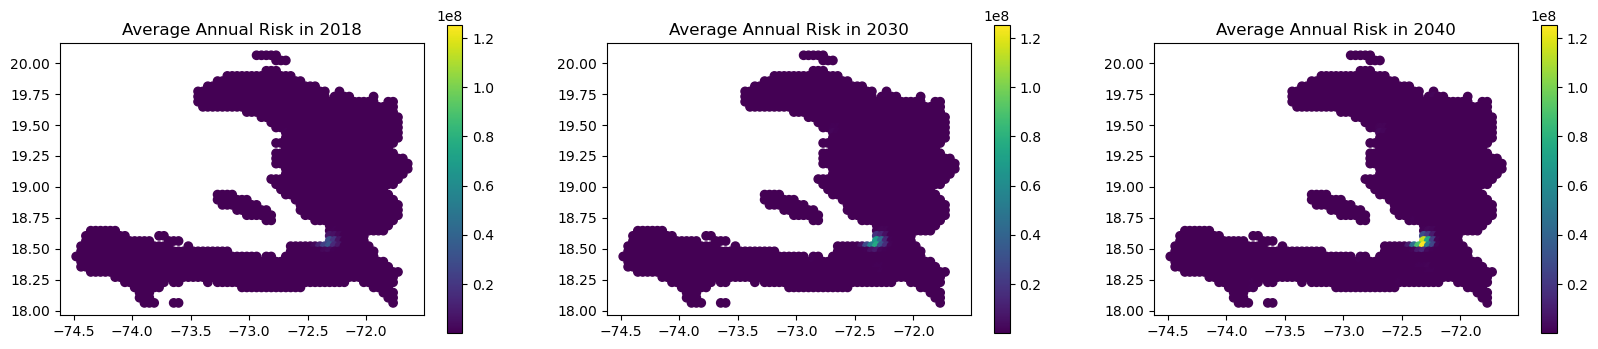

In [46]:
import matplotlib.pyplot as plt

gdf = snap.exposure.gdf
gdf["coord_id"] = gdf.index
gdf = gdf.merge(df, on="coord_id")

fig, axs = plt.subplots(1, 3, figsize=(20, 4))

gdf.loc[gdf["date"] == "2018-01-01"].plot(
    column="risk",
    legend=True,
    vmin=gdf["risk"].min(),
    vmax=gdf["risk"].max(),
    ax=axs[0],
)
gdf.loc[gdf["date"] == "2030-01-01"].plot(
    column="risk",
    legend=True,
    vmin=gdf["risk"].min(),
    vmax=gdf["risk"].max(),
    ax=axs[1],
)
gdf.loc[gdf["date"] == "2040-01-01"].plot(
    column="risk",
    legend=True,
    vmin=gdf["risk"].min(),
    vmax=gdf["risk"].max(),
    ax=axs[2],
)

axs[0].set_title("Average Annual Risk in 2018")
axs[1].set_title("Average Annual Risk in 2030")
axs[2].set_title("Average Annual Risk in 2040")

plt.show()